## C S 329E HW 9

# Clustering with DBSCAN

## Marissa Green

As we discussed in lecture DBSCAN creates clusters based on the density of the points in the vicinity of the data.  Using small example data sets, we will implement both algorithms and visualize the results.

Even though the example data is small and 2 dimensional, write your helper functions to not assume a 2-D data set.  Your plotting code can reference the `x` and `y` column names from the sample data directly. 

Note that I have added a one or two lines of code to the questions to test your implementations. 

In [1]:
# Do not import anything else
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN # only on last problem

# DBSCAN

## Q1 Load the Density Data and try K-means

Load in the data provided `data_dbscan.csv`, cluster it with k-means algorithm with $k=2$ and visualize the results with a scatter plot, where the color indicates cluster membership. Label your axes, and give the plot a title. Use the [scikit-learn implementation of K-means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

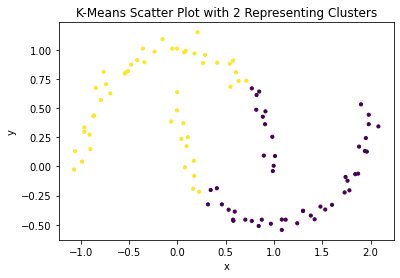

In [2]:
df_dbscan = pd.read_csv('data_dbscan.csv')

# Call k_means with k = 2
# or .fit_predict(df_dbscan) works 
kmeans = KMeans(n_clusters = 2).fit(df_dbscan)
kmeans_predict = kmeans.predict(df_dbscan)

plt.scatter(df_dbscan["x"], df_dbscan["y"], s=10, c=kmeans_predict)
plt.title("K-Means Scatter Plot with 2 Representing Clusters")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Q2.2 Write function to Implement Range Query

Using the [pseudo-code](https://en.wikipedia.org/wiki/DBSCAN#Algorithm) on wikipedia, implement RangeQuery.

```
RangeQuery(DB, distFunc, Q, eps) {
    Neighbors N := empty list
    for each point P in database DB {                      /* Scan all points in the database */
        if distFunc(Q, P) ≤ eps then {                     /* Compute distance and check epsilon */
            N := N ∪ {P}                                   /* Add to result */
        }
    }
    return N
}
```

The "DB" parameter is a data frame, `df_data` containing all of the points in our data set, the "distFunc" is set as Euclidean distance thus should not be passed in, the point "Q", is represented by the index of the data frame, `q_index`, where `df_data.iloc[q_index]` is the actual point, and `eps` is a floating point value that indicates the radius from the point "Q" to search for neighbors.  The function will return the slice of `df_data` of all points within `eps` distance of "Q" (including "Q").  The indices on the slice should be preserved (do not reset_index).  

In [3]:
def range_query( df_data, q_index, eps ):
    
    # get distances of all points
    distances = (df_data.iloc[q_index] - df_data).apply(np.linalg.norm, axis=1)
    
    # filter based on eps
    nearest_distances = distances[distances <= eps].index.values
    
    return df_data.iloc[nearest_distances]

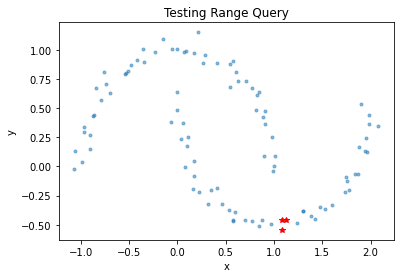

In [4]:
# Test it out
df_n = range_query( df_dbscan, 0, 0.1 )
plt.plot( df_dbscan['x'], df_dbscan['y'], '.', alpha = 0.5 )
plt.plot( df_n['x'], df_n['y'], 'r*')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Testing Range Query')
plt.show()

## Q2.3 Write a function to implement DBSCAN

Using the [pseudo-code](https://en.wikipedia.org/wiki/DBSCAN#Algorithm) on wikipedia, implement DBSCAN. This algorithm uses set notation, I found a handy summary on-line [here](http://www.math.cmu.edu/~bkell/21110-2010s/sets.html) if you need a refresher. 

```
DBSCAN(DB, distFunc, eps, minPts) {
    C := 0                                                  /* Cluster counter */
    for each point P in database DB {
        if label(P) ≠ undefined then continue               /* Previously processed in inner loop */
        Neighbors N := RangeQuery(DB, distFunc, P, eps)     /* Find neighbors */
        if |N| < minPts then {                              /* Density check */
            label(P) := Noise                               /* Label as Noise */
            continue
        }
        C := C + 1                                          /* next cluster label */
        label(P) := C                                       /* Label initial point */
        SeedSet S := N \ {P}                                /* Neighbors to expand */
        for each point Q in S {                             /* Process every seed point Q */
            if label(Q) = Noise then label(Q) := C          /* Change Noise to border point */
            if label(Q) ≠ undefined then continue           /* Previously processed (e.g., border point) */
            label(Q) := C                                   /* Label neighbor */
            Neighbors N := RangeQuery(DB, distFunc, Q, eps) /* Find neighbors */
            if |N| ≥ minPts then {                          /* Density check (if Q is a core point) */
                S := S ∪ N                                  /* Add new neighbors to seed set */
            }
        }
    }
}
```

The function should accept as parameters "DB", a data frame of points to be clustered, `df_data`, no distance function (assuming Euclidean distance), a floating point `eps` that defines the radius, and an integer `minPts`.  The function will return a series of cluster assignments of the same length as `df_data`. If the data is classified as noise, the cluster assignment is $0$, and all of the clusters will have a label of $1-k$, were $k$ is derived in the function and represents the total number of clusters found. 

Don't forget that [iterrows](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iterrows.html) is a lovely way to loop through a data frame. But if you modify the dataframe within the loop, it doesn't add more iterations to the loop.  For example, if you start with a dataframe of length $n$ and add $3$ rows, then the `iterrows` will stop after $n$ rows. For the inside loop, you'll need to use a native python list to dynamically grow the `SeedSet S`.  You can use the `extend` function to merge 2 lists together. For example:

```
x = [1,2,3]
y = [4,5,6]
x.extend(y) # sets x to the list [1, 2, 3, 4, 5, 6]
```

If you haven't used the [continue](https://docs.python.org/3/tutorial/controlflow.html) statement before, it can be useful in these situations, check out the link. 

Call `dbscan` with the `df_dbscan` data frame, `eps` set to 0.23, and `min_pts` set to 6 and save the results to `s_cluster_assignments` 

In [5]:
def dbscan( df_data, eps, min_pts ):
    
    #initializers
    NOISE_LABEL = 0 # upper case --> global constant variable 
    cluster_counter = 0
    # to initialize clutser assignment as all undefined (-1 for me)
    s_cluster_assignment = pd.Series(np.ones(len(df_data))).replace(to_replace=1, value=-1)
    # or s_cluster_assignment = np.ones(len(df_data))*np.nan
    
    # iterates through all the points id df_data. row is a point 
    for idx, row in df_data.iterrows():

        # if that point's cluster assignment is defined, skip this iteration and go to the next
        if s_cluster_assignment[idx] != -1:
            continue

        # AT THIS POINT, THE POINT'S CLUSTER ASSIGNMENT IS UNDEFINED
        df_neighbors = range_query( df_data, idx, eps )
        
        # not dense enough to be considered a border or core point. cluster assignment = noise point
        if len(df_neighbors) < min_pts:
            s_cluster_assignment[idx] = NOISE_LABEL
            continue
        
        # AT THIS POINT, THE POINT IS A BORDER OR CORE POINT
        cluster_counter += 1
        s_cluster_assignment[idx] = cluster_counter
        df_seed_set = df_neighbors.drop([idx]) # neighbors to expand 

        df_seed_set_indeces = list(df_seed_set.index)
        
        for seed_idx in df_seed_set_indeces: 
            
            
            if s_cluster_assignment[seed_idx] == NOISE_LABEL:
                s_cluster_assignment[seed_idx] = cluster_counter
            
            # previously processed 
            if s_cluster_assignment[seed_idx] != -1:
                continue
            
            s_cluster_assignment[seed_idx] = cluster_counter
            df_neighbors_seed = range_query( df_data, seed_idx, eps )
            
            # dynamically grow 
            if len(df_neighbors_seed) >= min_pts:
                # should have:
                # new_indeces = list(df_neighbors_seed.index[~df_neighbors_seed.index.isin(df_seed_set_indeces)])
                # if len(new_indeces) > 0:
                    # df_seed_set_indeces.extend(new_indeces)
                # instead of 
                df_seed_set_indeces.extend(list(df_neighbors_seed.index))
                
    return s_cluster_assignment

In [6]:
# Test it out
s_cluster_assignment = dbscan( df_dbscan, 0.23, 6)
s_cluster_assignment.value_counts()

1.0    49
2.0    48
0.0     3
dtype: int64

## Q2.4 Plot the Results 

Plot the points in the `df_dbscan` data frame using a 2-D scatter plot, with a different color for each cluster.  Use the cluster assignments from the previous problem (`s_cluster_assignments`). Label your axes, and give the plot a title.

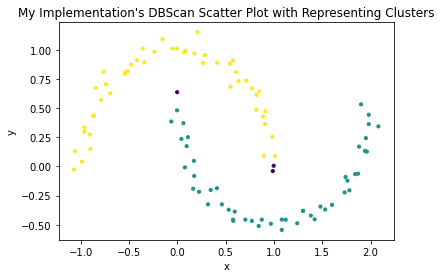

In [7]:
# Plot each cluster
plt.scatter(df_dbscan["x"], df_dbscan["y"], s=10, c=s_cluster_assignment)#, label = s_cluster_assignment)
plt.title("My Implementation's DBScan Scatter Plot with Representing Clusters")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Q2.5 Compare your results to the scikit-learn library

Import DBSCAN from scikit-learn and compare the cluster labels from your implementation to the cluster labels generated from [scikit-learn's DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html). Add some commentary about how you think the results compare. Use the same data and values for eps and minPts.

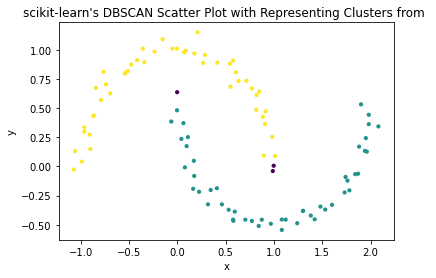

In [8]:
# check your implementation vs scikit-learn
dbscan = DBSCAN (eps = 0.23, min_samples = 6, metric = "euclidean")
dbscan_predict = dbscan.fit_predict(df_dbscan)

plt.scatter(df_dbscan["x"], df_dbscan["y"], s=10, c=dbscan_predict)
plt.title("scikit-learn's DBSCAN Scatter Plot with Representing Clusters from ")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

My implementation and scikit-learn's implementation of DBScan on this data set has the same output, with the same two clusters and three noise points. I hypothesized my method would take much longer than the built in method, and I was correct. In fact, when I used the time function to calculate how long each implementation took, I discovered my implementation took about 0.5 seconds while scikit-learn's way took only around 0.01 seconds. 

# correct answer: our nosie labels == 0, scikit learn nosie labels == -1 (everything off by one) 